In [183]:
# from synthetic import generate_synthetic_data
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt


In [6]:
def generate_synthetic_data (N=10000,):
    ''' Generate synthetic data according to prescribed destribution for state variables. 
        So far the scale and the distribution are fixed but we can relax that late.
        Arguments:
            N: sample size
        Returns:
            x1: wind speed drawn from Reyleigh distribution
            x2: temperature difference drawn from normal distribution
            y1: dictionary containing mean, std, and samples of momentum flux
            y2: dictionary containing mean, std, and samples of sensible heat flux
    '''
            
    # Wind speed
    scale = 5.
    x1 = np.random.rayleigh(scale, N)
    # Temperature diff
    mean, var = -0.8, 0.8
    x2 = np.random.normal(mean, var, N)
    # Bulk coefficients
    Cd = 0.0015 # For omentum, between 1e-3 to 2e-3
    Ch = 1 # For sensible heat, this is after multiplied by heat capacity

    # Fluxes
    y1_mean = Cd*x1**2; y1_std = Cd*x1**2*0.2 + 0.01
    y1_sample = y1_mean + np.array([np.random.normal(0,std,1).squeeze() for std in y1_std]) # This is kind of inefficient to generate random samples
    y2_mean = Ch*x1*x2; y2_std = abs(Ch*x1*x2)*0.15 + 1
    y2_sample = y2_mean + np.array([np.random.normal(0,std,1).squeeze() for std in y2_std])
    
    # Assemble
    y1 = {'mean':y1_mean,'std':y1_std,'sample':y1_sample}
    y2 = {'mean':y2_mean,'std':y2_std,'sample':y2_sample}
    return (x1,x2,y1,y2)

In [184]:
# TODO: does the attribute of Dataset need to be all tensors?
class FluxDataset(Dataset):
    def __init__(self, N=10000, choice='momentum'):
        
        # Generate data
        self.x1, self.x2, self.y1, self.y2 = generate_synthetic_data(N=N)
        self.X = torch.tensor(np.hstack([np.reshape(self.x1,(-1,1)),np.reshape(self.x2,(-1,1))]).astype('float32'))
        
        # A uniform grid flattened to make prediction maps
        # After making the prediction, Y_pred.reshape([100,100])
        x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
        x1_mesh, x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')
        X_uniform = np.hstack([np.reshape(x1_mesh,(-1,1)), np.reshape(x2_mesh,(-1,1))])
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        
        # Choice y
        if choice == 'momentum':
            self.Y = torch.tensor(np.reshape(self.y1['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y1['sample']-self.y1['mean'])**2)**0.5
        if choice == 'heat':
            self.Y = torch.tensor(np.reshape(self.y2['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y2['sample']-self.y2['mean'])**2)**0.5
        
    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    

In [185]:
# TODO: does the attribute of Dataset need to be all tensors?
class FluxDataset1D(Dataset):
    def __init__(self, N=10000, choice='momentum'):
        
        # Generate data
        self.x1, self.x2, self.y1, self.y2 = generate_synthetic_data(N=N)
        self.X = np.reshape(self.x1,(-1,1)).astype('float32')
        
        # A uniform grid flattened to make prediction maps
        # After making the prediction, Y_pred.reshape([100,100])
        x1_vis = np.linspace(0,20,100)
        X_uniform = np.reshape(x1_vis,(-1,1))
        self.X_uniform = torch.tensor(X_uniform.astype('float32'))
        
        # Choice y
        if choice == 'momentum':
            self.Y = torch.tensor(np.reshape(self.y1['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y1['sample']-self.y1['mean'])**2)
        if choice == 'heat':
            self.Y = torch.tensor(np.reshape(self.y2['sample'],(-1,1)).astype('float32'))
            self.min_MSE = np.average((self.y2['sample']-self.y2['mean'])**2)
        
    def __len__(self):
        return len(self.x1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [272]:
dataset = FluxDataset(N=100000, choice='momentum')
# dataset = FluxDataset1D(N=100000, choice='momentum')

dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [298]:
# Define a fully connected neural network with one hidden layer
class FcNet(nn.Module):
    def __init__(self, hidden_dim=16):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
# class FcNet(nn.Module):
#     def __init__(self, hidden_dim=16):
#         super().__init__()
#         self.fc1 = nn.Linear(1, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, 1)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
mean_net = FcNet()
var_net = FcNet()
# mean_net.to('mps')
# var_net.to('mps')

In [299]:
''' Variance network trained on log likelihood '''

optimizer_joint = optim.Adam(list(var_net.parameters())+list(mean_net.parameters()), lr=1e-3)
# optimizer_joint = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 50
log_var = {'LLLoss': [], 'var': [], 'mean': []}

loss = nn.GaussianNLLLoss()

for epoch in range(num_epochs):
    LLLoss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        optimizer_joint.zero_grad()
        # Forward pass
        mean = mean_net(inputs)
        var = (var_net(inputs))**2 # squared to predict positive variance
        likelihood = loss(targets, mean, var).mean()   
        # Backward and optimize (var and mean net)
        likelihood.backward() # TODO: Only need to call this once right?
        optimizer_joint.step()
        LLLoss += likelihood.item() * len(inputs)        

    LLLoss = LLLoss / len(dataset)
    var = (var_net(dataset.X_uniform))**2
    mean = mean_net(dataset.X_uniform)
    log_var['LLLoss'].append(LLLoss)
    log_var['var'].append(var.detach())
    log_var['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {LLLoss:.8f}")

Epoch [1/50], Loss: -1.61682191
Epoch [2/50], Loss: -1.71506278
Epoch [3/50], Loss: -1.42215668
Epoch [4/50], Loss: -1.47812679
Epoch [5/50], Loss: -2.24494431
Epoch [6/50], Loss: -2.78609981
Epoch [7/50], Loss: -2.81501823
Epoch [8/50], Loss: -3.06770149
Epoch [9/50], Loss: -3.07726457
Epoch [10/50], Loss: -2.97208651
Epoch [11/50], Loss: -3.10463066
Epoch [12/50], Loss: -2.95641814
Epoch [13/50], Loss: -3.04011617
Epoch [14/50], Loss: -3.09840809
Epoch [15/50], Loss: -2.28915499
Epoch [16/50], Loss: -1.98670904
Epoch [17/50], Loss: -1.81518511
Epoch [18/50], Loss: -2.43036314
Epoch [19/50], Loss: -2.07468576
Epoch [20/50], Loss: -3.19848848
Epoch [21/50], Loss: -3.09842818
Epoch [22/50], Loss: -3.21696137
Epoch [23/50], Loss: -3.10108335
Epoch [24/50], Loss: -3.18672523
Epoch [25/50], Loss: -2.46391847
Epoch [26/50], Loss: -1.82313467
Epoch [27/50], Loss: -3.22644784
Epoch [28/50], Loss: -3.24218361
Epoch [29/50], Loss: -3.20380717
Epoch [30/50], Loss: -3.18948727
Epoch [31/50], Loss

Text(0, 0.5, 'Loss')

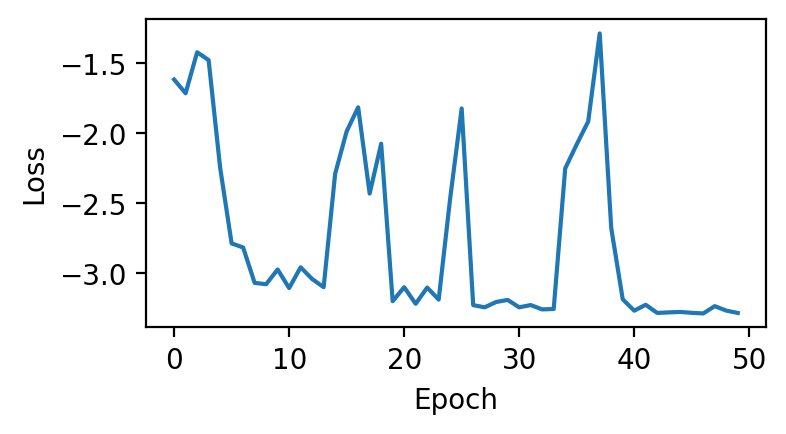

In [300]:
plt.figure(figsize=[4,2],dpi=200)
plt.plot(log_var['LLLoss'])
plt.xlabel('Epoch'); plt.ylabel('Loss')
# plt.ylim([1,1.1])

In [204]:
x1_vis = np.linspace(0,20,100); x2_vis = np.linspace(-2,2,100)
x1_mesh,x2_mesh = np.meshgrid(x1_vis,x2_vis,indexing='ij')

In [197]:
def plot_epoch(epoch=10, xaxis=1):
    ''' Input:
            xaxis: the x axis variable to display. The prediction of the mean is then 
            averaged along the other dimensions. 0: wind speed; 1: temp diff. 
    '''
    plt.figure(figsize=(4,4))
    plt.plot(dataset.X[:2000, xaxis], dataset.Y[:2000], '.', label='training \ndata')

    mean = log_var['mean'][epoch]
    std = np.sqrt(log_var['var'][epoch])

    dims = [0,1] # for total dimension 2. TODO: refine it later
    dims.remove(xaxis) # axis except for the one specified
    mean_aver = np.average(mean.reshape(100,100), axis=tuple(dims)); std_aver = np.average(std.reshape(100,100), axis=tuple(dims))
    
    if xaxis == 0:
        xplot = dataset.X_uniform[:,xaxis].reshape(100,100)[0]
    elif xaxis == 1:
        xplot = dataset.X_uniform[:,xaxis].reshape(100,100)[:,0]
        
    plt.plot(xplot,mean_aver,'-', lw=1, color='k', label='Expectation')
    plt.plot(xplot,mean_aver-std_aver,'--', lw=1, color='k', label='$\pm \sigma$')
    plt.plot(xplot,mean_aver+std_aver,'--', lw=1, color='k')
        
#     plt.xlim([0,20])
#     plt.xticks([0,5,10,15,20])
#     plt.ylim([0,0.8])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Prediction by ANN')

In [302]:
def plot_epoch_map(epoch=10):
    ''' Input:
            xaxis: the x axis variable to display. The prediction of the mean is then 
            averaged along the other dimensions. 0: wind speed; 1: temp diff. 
    '''
    plt.figure(figsize=(4,3))
    # plt.plot(dataset.X[:2000, xaxis], dataset.Y[:2000], '.', label='training \ndata')
    img = plt.pcolormesh(dataset.X_uniform[:,0].numpy().reshape(100,100), dataset.X_uniform[:,1].numpy().reshape(100,100),
                         log_var['mean'][epoch].reshape(100,100), vmax=1, vmin=0)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
#     plt.legend(loc='upper left', fontsize=12)
    plt.colorbar(img, ticks=[0,1])
    plt.title('Epoch %g' %epoch)

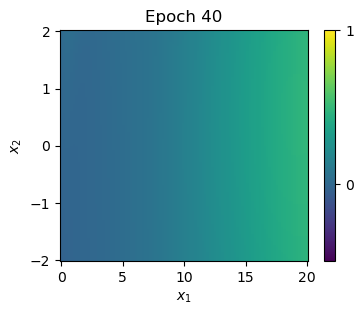

In [296]:
plot_epoch_map(40)

Text(0.5, 1.0, 'True $\\mu$')

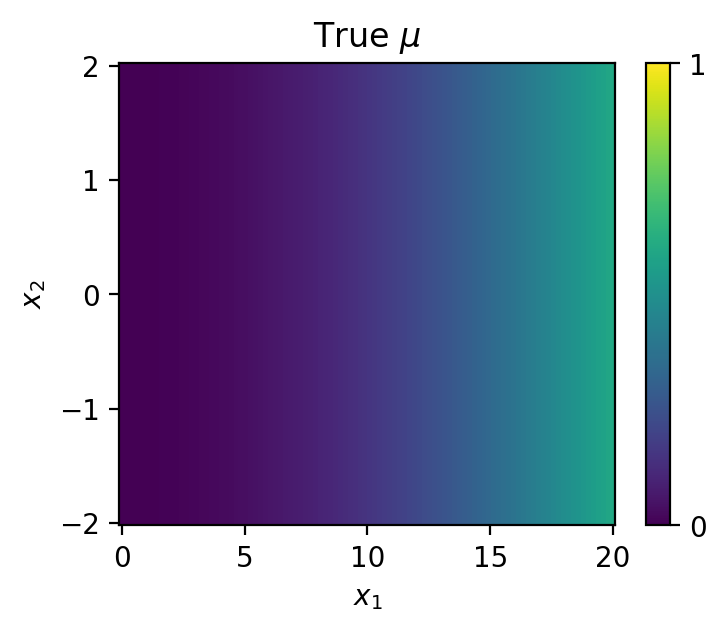

In [280]:
plt.figure(figsize=(4,3), dpi=200)
X = dataset.X_uniform[:,0].numpy().reshape(100,100)
Y = dataset.X_uniform[:,1].numpy().reshape(100,100)
img = plt.pcolormesh(X, Y, 0.0015*X**2, vmax=1, vmin=0)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(img, ticks=[0,1])
plt.title('True $\mu$')

In [304]:
create_animation(plot_epoch_map, idx=np.arange(0,50,1), filename='momentum_2DMap_mu.gif', FPS=10)

Animation at FPS=10 will last for 5.0 seconds


In [60]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

def create_animation(fun, idx, filename='my-animation.gif', dpi=200, FPS=18, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi, bbox_inches='tight')
        plt.close()
        frames.append(Image.open('.frame.png').convert('RGB'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [303]:
create_animation(plot_epoch, idx=np.arange(0,50,1), filename='FluxUQ.gif', FPS=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Animation at FPS=10 will last for 5.0 seconds


In [ ]:
''' Train mean and then variance on MSE and then variance and mean on MLE ''' 
optimizer = optim.Adam(mean_net.parameters(), lr=1e-3)
num_epochs = 20
log = {'MSE': [], 'mean': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        MSE = ((mean-targets)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    mean = mean_net(dataset.X_uniform)
    log['MSE'].append(MSE_loss)
    log['mean'].append(mean.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.4f}/{dataset.min_MSE:.4f}")
    
    
optimizer = optim.Adam(var_net.parameters(), lr=1e-3)
num_epochs = 30
log_var = {'MSE': [], 'var': []}
for epoch in range(num_epochs):
    MSE_loss = 0.
    for i, (inputs, targets) in enumerate(dataloader):
        # Forward pass
        mean = mean_net(inputs)
        r2 = (targets-mean)**2
        var = (var_net(inputs))**2 # squared to predict positive variance
        MSE = ((var-r2)**2).mean()

        # Backward and optimize
        optimizer.zero_grad()
        MSE.backward()
        optimizer.step()
        MSE_loss += MSE.item() * len(inputs)

    MSE_loss = MSE_loss / len(dataset)
    var = (var_net(dataset.X_uniform))**2
    log_var['MSE'].append(MSE_loss)
    log_var['var'].append(var.detach())

    # Print loss after every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {MSE_loss:.6f}")
    
